In [ ]:
import joblib
import pickle
import os
file_path = './data/joblibs/labels.joblib'
gdf = joblib.load(file_path)
gdf = gdf.to_crs(crs='EPSG:4326')
gdf.head()

In [ ]:
import new_app
import shapely.geometry
import data_downloader

total_bounds = gdf.total_bounds
total_polygon = shapely.geometry.box(*total_bounds, ccw=True)
dates = new_app.get_available_dates_from_sentinelhub(polygon, year='2023')


In [51]:
import os
import pandas as pd

,date,location,evalscript,identifier,file_name
0,2019-04-28,gaziera,CLP,04464e330f63d35ea6a51fb10b3e5d3b,response.tiff
1,2019-04-28,gaziera,FCOVER,75e77f41937093f5479ce0b795fac79e,response.tiff
2,2019-04-28,gaziera,TRUECOLOR,b26d60fc0b1210934bb9616ecdf630e1,response.png


In [32]:
file_path

'./data/satellite_images\\2019-04-28\\gaziera\\FCOVER\\75e77f41937093f5479ce0b795fac79e\\response.tiff'

In [ ]:
from PIL import Image
im = Image.open(file_path)
im.show()

In [ ]:
import numpy as np
imarray = np.array(im)

print(f'Shape of the image array: {imarray.shape}')
print(f'Minimum value in the array: {imarray.min()}')
print(f'Maximum value in the array: {imarray.max()}')
print(f'Mean value in the array: {imarray.mean()}')
print(f'Std value in the array: {imarray.std()}')
print(f'Number of unique values in the array: {len(np.unique(imarray))}')
print(f'Unique values in the array: {np.unique(imarray)}')
print(f'Number of pixels in the array: {imarray.size}')

In [44]:
file_path = './data/satellite_images/2019-04-28/gaziera/TRUECOLOR/b26d60fc0b1210934bb9616ecdf630e1/response.png'

In [45]:
imagePath

'data\\satellite_images\x819-04-28\\gaziera\\TRUECOLOR\x0826d60fc0b1210934bb9616ecdf630e1\response.png'

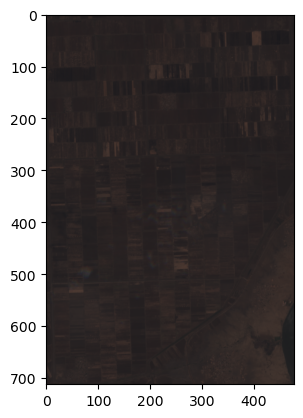

uint8
None
| 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|


In [55]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

imagePath = file_path
band4 = rasterio.open(imagePath)
plot.show(band4)
print(band4.dtypes[0])
print(band4.crs)
print(band4.transform)


#convert band4 bands into dataframe
bands = []
for i in range(1, band4.count + 1):
    band = band4.read(i)
    bands.append(band)
bands = np.array(bands)
bands = bands.reshape(band4.count, img.width * img.height)
bands = bands.T
bands = pd.DataFrame(bands)

In [56]:
bands

,0,1,2
0,41,37,36
1,42,36,36
2,47,40,38
3,41,35,35
4,38,34,34
...,...,...,...
339619,46,41,40
339620,38,36,36
339621,39,38,38
339622,36,35,36


In [53]:
band4

<open DatasetReader name='./data/satellite_images/2019-04-28/gaziera/TRUECOLOR/b26d60fc0b1210934bb9616ecdf630e1/response.png' mode='r'>

In [52]:
plot.show??

Signature:
plot.show(
    source,
    with_bounds=True,
    contour=False,
    contour_label_kws=None,
    ax=None,
    title=None,
    transform=None,
    adjust=False,
    **kwargs,
)
Source:   
def show(source, with_bounds=True, contour=False, contour_label_kws=None,
         ax=None, title=None, transform=None, adjust=False, **kwargs):
    """Display a raster or raster band using matplotlib.

    Parameters
    ----------
    source : array or dataset object opened in 'r' mode or Band or tuple(dataset, bidx)
        If Band or tuple (dataset, bidx), display the selected band.
        If raster dataset display the rgb image
        as defined in the colorinterp metadata, or default to first band.
    with_bounds : bool (opt)
        Whether to change the image extent to the spatial bounds of the image,
        rather than pixel coordinates. Only works when source is
        (raster dataset, bidx) or raster dataset.
    contour : bool (opt)
        Whether to plot the raster data as 

In [50]:
band4.read(4).shape

IndexError: band index 4 out of range (not in (1, 2, 3))

In [ ]:

#type of raster byte
band4.dtypes[0]
#raster sytem of reference
band4.crs
#raster transform parameters
band4.transform
#raster values as matrix array
band4.read(1)
#multiple band representation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot.show(band2, ax=ax1, cmap='Blues')
plot.show(band3, ax=ax2, cmap='Greens')
plot.show(band4, ax=ax3, cmap='Reds')
fig.tight_layout()
#export true color image
trueColor = rasterio.open('../Output/SentinelTrueColor2.tiff','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )
trueColor.write(band2.read(1),3) #blue
trueColor.write(band3.read(1),2) #green
trueColor.write(band4.read(1),1) #red
trueColor.close()
src = rasterio.open(r"../Output/SentinelTrueColor2.tiff", count=3)
plot.show(src)
#export false color image
falseColor = rasterio.open('../Output/SentinelFalseColor.tiff', 'w', driver='Gtiff',
                          width=band2.width, height=band2.height,
                          count=3,
                          crs=band2.crs,
                          transform=band2.transform,
                          dtype='uint16'                   
                         )
falseColor.write(band3.read(1),3) #Blue
falseColor.write(band4.read(1),2) #Green
falseColor.write(band8.read(1),1) #Red
falseColor.close()
#generate histogram
trueColor = rasterio.open('../Output/SentinelTrueColor2.tiff')
plot.show_hist(trueColor, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

In [ ]:
imarray.mean()

In [ ]:
imarray.std()